In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from numba import jit

In [2]:
## set some parameters for the model
N = 250
beta = .96
delta = .06
alpha = .36
trans_mat = np.array([[.9,.1],[.9,.1]])
u = .1

In [3]:
@jit
def mp_r(k_bar, u, alpha):
    r = alpha * k_bar ** (alpha-1) * (1-u)**(1-alpha)
    return r
@jit
def mp_w(k_bar, u, alpha):
    w = (1-alpha) * k_bar**alpha * (1-u)**(-alpha)
    return w
@jit
def utility(c):
    if c < 0:
        return -10000
    U = np.log(c)
    return U

In [4]:
@jit
def bellman_eqn(k_prime, k_prime_ind, *params):
    val_func, k, r_k_bar, w_k_bar, eps, eps_ind, \
    delta, beta, trans_mat = params
    
    u_kprime = utility(r_k_bar*k + eps*w_k_bar + (1-delta)*k - k_prime)
    expectation = trans_mat[:,eps_ind] @ val_func[:, k_prime_ind]
    value = u_kprime + beta*expectation

    return value

In [12]:
##perform value function iteration
k_bar_guess = 10.125646475903626
k_grid = np.linspace(0.001, 40, N)
num_shocks = 2
maxiter = 2000
mindist = 1e-8
shocks = np.array([1,0])
val_guess = np.tile(np.log(k_grid + 1), (num_shocks, 1))
params = (num_shocks, shocks, maxiter, mindist, beta, delta, alpha, trans_mat, u, val_guess)



In [13]:
@jit(nopython=True)
def VFI(k_bar_guess, k_grid,  *params, ):
    num_shocks, shocks, maxiter, mindist, beta, delta, alpha, trans_mat, u, val_guess = params
    dist = 100
    val_iter = 0
    init_val = val_guess
    updated_val = init_val
    init_policy = np.ones(init_val.shape)
    updated_policy = np.zeros(init_val.shape)
    r_k_bar = mp_r(k_bar_guess, u, alpha)
    w_k_bar = mp_w(k_bar_guess, u, alpha)
    while (val_iter < maxiter) and (dist > mindist):
        val_iter += 1
        init_val = updated_val
        updated_val = np.zeros(init_val.shape)
        updated_policy = np.zeros(init_val.shape)

        for i in range(len(k_grid)):

            for j in range(num_shocks):

                k_index = i
                k = k_grid[i]
                eps = shocks[j]
                eps_ind = j

                params2 = (init_val, k, r_k_bar, w_k_bar, eps, eps_ind, \
                          delta, beta, trans_mat)
                vals = np.zeros(len(k_grid))
                count = 0
                for t in range(len(k_grid)):
                    kprime = k_grid[t]
                    val = bellman_eqn(kprime, t,  *params2)
                    vals[count] = val

                    count +=1
                #print("Vals:  {}".format(vals))
                updated_val[eps_ind, k_index] = vals[np.argmax(vals)]
                updated_policy[eps_ind, k_index] = k_grid[np.argmax(vals)]

        dist = ((updated_val - init_val) ** 2).sum()
#         if val_iter %5 == 0:
#             print('Iteration=', val_iter, ', Dist=', dist)
    return updated_val, updated_policy

In [14]:
%%time
value_function, policy_function = VFI(k_bar_guess, k_grid, *params)

CPU times: user 14.4 s, sys: 64.1 ms, total: 14.4 s
Wall time: 14.4 s


In [15]:
@jit(nopython=True)
def simulate_agent(policy_function, period_length, k_grid, guess_ind):
    np.random.seed(0)
    k_time_series = np.zeros(period_length)
    k_time_series[0] = k_grid[guess_ind]
    k_time_inds = np.empty(period_length, dtype=np.int64)
    k_time_inds[0] = guess_ind
    for i in range(1, period_length):
        rand_num = np.random.random()
        if rand_num > .1:
            state = 0
        else: state = 1
        k_time_series[i] = policy_function[state, k_time_inds[i-1]]
        k_time_inds[i] = np.where(k_grid == k_time_series[i])[0][0]
    avg_k = np.mean(k_time_series)
    #plt.plot(np.linspace(0, period_length, period_length), k_time_series)
    return avg_k

In [9]:
#simulate_agent(policy_function, 200, k_grid, 45)


In [16]:
params = (num_shocks, shocks, maxiter, mindist, beta, \
          delta, alpha, trans_mat, u, val_guess)

k_bar_guess = 7.229734939759037
@jit(nopython=True)
def find_kstar(k_bar_guess, k_grid, itermax, tol, *params):
    k_bar = 0
    k_bar_ind = 0
    dist = 100
    iter_num = 0
    value_function = np.zeros((2, 250))
    policy_function = np.zeros((2,250))
    while dist > tol and iter_num < itermax:
        iter_num +=1 
        k_bar_ind = np.argmin(np.abs(k_grid - k_bar_guess))
        value_function, policy_function = VFI(k_bar_guess, k_grid, *params,)
        
        k_bar = simulate_agent(policy_function, 500, k_grid, k_bar_ind)
        
        dist = np.abs(k_bar - k_bar_guess)
        k_bar_guess = k_bar
        print(k_bar)
        #print('Iteration {}, Distance {}, k_bar {}'.format(iter_num, dist,k_bar))
    k_star = k_bar_guess
    return k_star
        
    

In [ ]:
k_star = find_kstar(k_bar_guess, k_grid, 1000, .1,  *params)

15.8158656626506
9.211613102409654
11.093092168674708
9.662204246987956
10.611578102409648
9.90155569277109
10.44170283132531
10.032074518072296
10.301545692771095
10.125646475903626
10.275441927710853
10.125646475903626
10.275441927710853
10.125646475903626
10.275441927710853
10.125646475903626
10.275441927710853
10.125646475903626
10.275441927710853


In [17]:
k_star = 10.125646475903626
interest_rate = mp_r(k_star, u, alpha)

In [18]:
interest_rate

0.07647986983215915

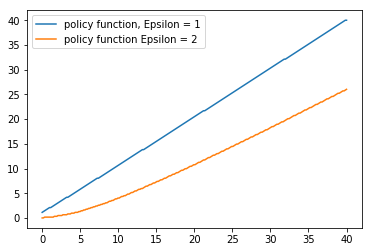

In [20]:
plt.plot(k_grid, policy_function[0], label = 'policy function, Epsilon = 1')
plt.plot(k_grid, policy_function[1], label= 'policy function Epsilon = 2')
plt.legend()
plt.show()

The steady state interest rate is lower in this economy than in a representative agent economy, this is because heterogenous agents save more as a precaution for employment shocks. 